## Additional Testing for IntOpt - MLP

In [111]:
import torch
import numpy as np

class QuantizerScheme:  
    def __init__(self, t, b):  
        self.b = np.floor(b)  
        self.t = t
        self.incr = 1
        
        if b <= 0:
            raise Exception("QuantizerScheme: 'b' must be greater than 0.")
        
        if t <= 0 or t >= 1:
            raise Exception("QuantizerScheme: 't' must be between 0 and 1.")
        
        #Bitwidth (b) produces a number of values equal to 2^b
        bs = 2 ** b
        
        #Value 0 is always 0. Value Max is always 1.
        self.vals = np.zeros(bs)
        self.vals[bs - 1] = 1
        
        #For the values in between, it is equally spaced gaps between t and 1, including t.
        #If bitwidth is 1, then only 0 and 1 are options.
        
        if b > 1:
            self.incr = (1 - t) / (bs - 2) #The increment for steps between t and 1
            #valuesToCreate
            vtc = bs - 2
            for i in range(vtc):
                nv = t + (i * self.incr)
                self.vals[i + 1] = nv
                
        print(self.vals)
    
    @torch.no_grad()
    def Quantize(self, val):
        low = 0
        high = 1
        neg = 1
        if val < 0:
            neg = -1
        val = abs(val)
        for i in range(self.vals.__len__()):
            if val == self.vals[i]:
                low = val
                high = val
            if val > self.vals[i]:
                if i != self.vals.__len__() - 1:
                    low = self.vals[i]
                    high = self.vals[i + 1]
        
        if low == high: #Exact match
            return val
        else:
            sampl = np.random.uniform(low=low, high=high) - low
            hprob = (val - low)/self.incr
            prob = sampl/self.incr
            #If prob < hprob, round to the high, else round to the low
            if prob < hprob:
                val = high
            else:
                val = low
        return (val * neg)

In [112]:
import torch
from torch.optim.optimizer import Optimizer, required
import torch.optim._functional as _F

class IntOptAdam(Optimizer): #Intensity Optimizer
    def __init__(self, params, t, b, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False, *, maximize: bool = False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad, maximize=maximize, t=t, b=b)
        
        self.qs = QuantizerScheme(t, b)
        
        super(IntOptAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']
            t = group['t']
            b = group['b']
            
            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    # update the steps for each param group update
                    state['step'] += 1
                    # record the step after step update
                    state_steps.append(state['step'])

            _F.adam(params_with_grad,
                   grads,
                   exp_avgs,
                   exp_avg_sqs,
                   max_exp_avg_sqs,
                   state_steps,
                   amsgrad=group['amsgrad'],
                   beta1=beta1,
                   beta2=beta2,
                   lr=group['lr'],
                   weight_decay=group['weight_decay'],
                   eps=group['eps'])
            
            for p in group['params']:
                if(p.shape.__len__() > 0):
                    zs = torch.zeros(p.shape)
                    p = torch.where(p > t, p, zs)
                    p = p.detach().apply_(self.qs.Quantize)

        return loss

In [113]:
#MLP Source: https://www.kaggle.com/pinocookie/pytorch-simple-mlp

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [114]:
class MNIST(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X.index)
    
    def __getitem__(self, index):
        image = self.X.iloc[index, ].values.astype(np.uint8).reshape((28, 28, 1))
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.y is not None:
            return image, self.y.iloc[index]
        else:
            return image

In [115]:
train_df = pd.read_csv('C:\\Users\\554850\\ADL Project\\input\\train.csv')
test_df = pd.read_csv('C:\\Users\\554850\\ADL Project\\input\\test.csv')

print('train data shape : ', train_df.shape)
print('test data shape : ', test_df.shape)

X_train, X_valid, y_train, y_valid = \
    train_test_split(train_df.iloc[:, 1:], train_df['label'], test_size=1/6, random_state=42)

X_test = test_df

print('train image shape : ', X_train.shape)
print('train label shape : ', y_train.shape)
print('valid image shape : ', X_valid.shape)
print('valid label image : ', y_valid.shape)
print('test image shape  : ', X_test.shape)

train data shape :  (42000, 785)
test data shape :  (28000, 784)
train image shape :  (35000, 784)
train label shape :  (35000,)
valid image shape :  (7000, 784)
valid label image :  (7000,)
test image shape  :  (28000, 784)


In [116]:
transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_dataset = MNIST(X=X_train, y=y_train, transform=transform)
valid_dataset = MNIST(X=X_valid, y=y_valid, transform=transforms.ToTensor())
test_dataset = MNIST(X=X_test, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [117]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print('images shape on PyTroch : ', images.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([128, 1, 28, 28])
labels shape on PyTroch :  torch.Size([128])


(-0.5, 151.5, 151.5, -0.5)

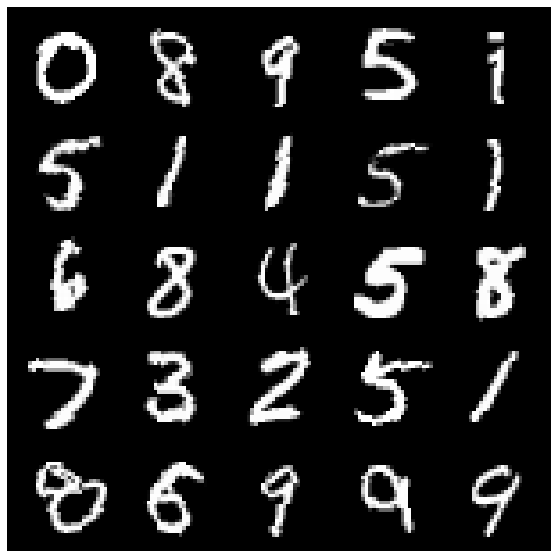

In [118]:
grid = make_grid(images[:25], nrow=5)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(grid.numpy().transpose((1, 2, 0)))
ax.axis('off')

In [119]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 90),
            nn.ReLU(),
            nn.Linear(90, 80),
            nn.ReLU(),
            nn.Linear(80, 70),
            nn.ReLU(),
            nn.Linear(70, 60),
            nn.ReLU(),
            nn.Linear(60, 50),
            nn.ReLU(),
            nn.Linear(50, 40),
            nn.ReLU(),
            nn.Linear(40, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

In [120]:
model = MLP()
print(model)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = IntOptAdam(model.parameters(), .1, 5, lr=0.001)
loss_fn = nn.CrossEntropyLoss()



MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=90, bias=True)
    (3): ReLU()
    (4): Linear(in_features=90, out_features=80, bias=True)
    (5): ReLU()
    (6): Linear(in_features=80, out_features=70, bias=True)
    (7): ReLU()
    (8): Linear(in_features=70, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=40, bias=True)
    (13): ReLU()
    (14): Linear(in_features=40, out_features=30, bias=True)
    (15): ReLU()
    (16): Linear(in_features=30, out_features=20, bias=True)
    (17): ReLU()
    (18): Linear(in_features=20, out_features=10, bias=True)
  )
)
[0.   0.1  0.13 0.16 0.19 0.22 0.25 0.28 0.31 0.34 0.37 0.4  0.43 0.46
 0.49 0.52 0.55 0.58 0.61 0.64 0.67 0.7  0.73 0.76 0.79 0.82 0.85 0.88
 0.91 0.94 0.97 1.  ]


In [121]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 10

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, (images, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (i * 128) % (128 * 100) == 0:
            print(f'{i * 128} / 50000')
            
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))

0 / 50000
12800 / 50000
25600 / 50000
epoch : 1, train loss : 1.2739, valid loss : 0.6215, valid acc : 81.00%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 2, train loss : 0.5358, valid loss : 0.4721, valid acc : 85.37%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 3, train loss : 0.3775, valid loss : 0.2906, valid acc : 91.91%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 4, train loss : 0.3041, valid loss : 0.2518, valid acc : 92.99%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 5, train loss : 0.2564, valid loss : 0.2394, valid acc : 93.47%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 6, train loss : 0.2226, valid loss : 0.2325, valid acc : 93.21%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 7, train loss : 0.1990, valid loss : 0.2006, valid acc : 94.46%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 8, train loss : 0.1829, valid loss : 0.1931, valid acc : 94.63%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 9, train loss : 0.1623, valid loss : 0.1797, valid acc : 94.89%
0 / 50000


In [46]:
#Baseline
print(valid_acc_list)

[81.0, 88.58571428571429, 89.28571428571429, 91.94285714285714, 93.31428571428572, 93.94285714285714, 94.68571428571428, 95.04285714285714, 95.25714285714285, 95.51428571428572]


In [110]:
#t = 0.1, b = 2
print(valid_acc_list)

[62.6, 80.14285714285714, 86.68571428571428, 90.65714285714286, 91.21428571428571, 91.32857142857142, 92.24285714285715, 93.71428571428571, 94.58571428571429, 94.31428571428572]


In [122]:
#t = 0.1, b = 5
print(valid_acc_list)

[81.0, 85.37142857142857, 91.91428571428571, 92.98571428571428, 93.47142857142858, 93.21428571428571, 94.45714285714286, 94.62857142857143, 94.88571428571429, 95.17142857142858]


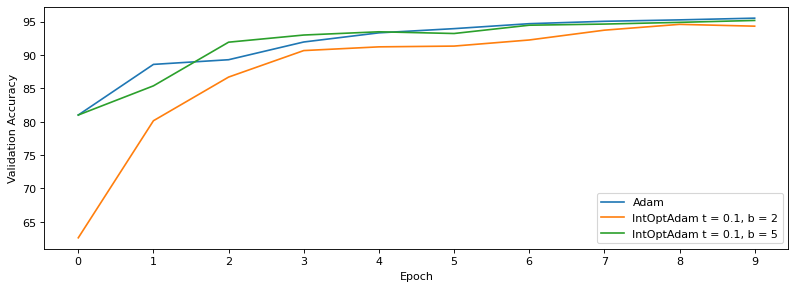

In [126]:
accs = []
accs.append([81.0, 88.58571428571429, 89.28571428571429, 91.94285714285714, 93.31428571428572, 93.94285714285714, 94.68571428571428, 95.04285714285714, 95.25714285714285, 95.51428571428572])
accs.append([62.6, 80.14285714285714, 86.68571428571428, 90.65714285714286, 91.21428571428571, 91.32857142857142, 92.24285714285715, 93.71428571428571, 94.58571428571429, 94.31428571428572])
accs.append([81.0, 85.37142857142857, 91.91428571428571, 92.98571428571428, 93.47142857142858, 93.21428571428571, 94.45714285714286, 94.62857142857143, 94.88571428571429, 95.17142857142858])

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

glabels = ["Adam", "IntOptAdam t = 0.1, b = 2", "IntOptAdam t = 0.1, b = 5"]

figure(figsize=(12,4), dpi=80)
for i in range(3):
    plt.plot(accs[i], label=glabels[i])
plt.xticks(np.arange(0, 10, 1.0))
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()


In [140]:
qsn = QuantizerScheme(.1, 5)
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        valid_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

for j in range(10):
    k = j * 2
    x = model.layers[k].weight
    x = x.detach().apply_(qsn.Quantize)
    fz = x[x==0].__len__()
    ft = x.shape[0]*x.shape[1]
    print("Layer: {}  Sparsity Proportion: {}".format(j, fz/ft))

with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        valid_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
print(correct/total)

[0.   0.1  0.13 0.16 0.19 0.22 0.25 0.28 0.31 0.34 0.37 0.4  0.43 0.46
 0.49 0.52 0.55 0.58 0.61 0.64 0.67 0.7  0.73 0.76 0.79 0.82 0.85 0.88
 0.91 0.94 0.97 1.  ]
Layer: 0  Sparsity Proportion: 0.5594005102040817
Layer: 1  Sparsity Proportion: 0.37833333333333335
Layer: 2  Sparsity Proportion: 0.3836111111111111
Layer: 3  Sparsity Proportion: 0.37839285714285714
Layer: 4  Sparsity Proportion: 0.37
Layer: 5  Sparsity Proportion: 0.3393333333333333
Layer: 6  Sparsity Proportion: 0.341
Layer: 7  Sparsity Proportion: 0.3016666666666667
Layer: 8  Sparsity Proportion: 0.24833333333333332
Layer: 9  Sparsity Proportion: 0.16
0.8881208791208791


No handles with labels found to put in legend.


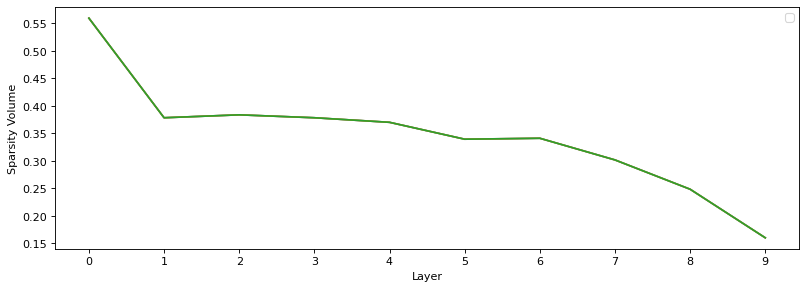

0.34598


In [144]:
import numpy

sparsity = [0.5594, 0.3783, 0.3836, 0.3783, 0.3700, 0.3393, 0.3410, 0.3016, 0.2483, 0.1600]
figure(figsize=(12,4), dpi=80)
for i in range(3):
    plt.plot(sparsity)
plt.xticks(np.arange(0, 10, 1.0))
plt.xlabel("Layer")
plt.ylabel("Sparsity Volume")
plt.legend()
plt.show()

print(numpy.average(sparsity))

In [139]:
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        valid_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

In [131]:
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=90, bias=True)
    (3): ReLU()
    (4): Linear(in_features=90, out_features=80, bias=True)
    (5): ReLU()
    (6): Linear(in_features=80, out_features=70, bias=True)
    (7): ReLU()
    (8): Linear(in_features=70, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=40, bias=True)
    (13): ReLU()
    (14): Linear(in_features=40, out_features=30, bias=True)
    (15): ReLU()
    (16): Linear(in_features=30, out_features=20, bias=True)
    (17): ReLU()
    (18): Linear(in_features=20, out_features=10, bias=True)
  )
)
